In [1]:
import pandas as pd

In [2]:
# Cell line structure data frame, columns are cell lines, rows are gene mutations ordered by descending frequency
mutation_df = pd.read_csv("../dataset/Cancer/binary_mutations.csv")
# Response data frame, columns have cell line name, drug name and auc score
response_df = pd.read_csv("../dataset/Cancer/cell_drug_responses.csv")
# Drug structure data frame, columns are drug name, rows are morgan footprint entries
morgan_footprints_df = pd.read_csv("../dataset/Cancer/morgan_footprints.csv")

In [3]:
depmap_mutation_ref = pd.read_csv("../dataset/Cancer/mutations_NAsdropped.csv")

/tmp/ipykernel_7049/535314877.py:1: DtypeWarning: Columns (23,25,29,30,31,42,53,55) have mixed types. Specify dtype option on import or set low_memory=False.
  depmap_mutation_ref = pd.read_csv("../dataset/Cancer/mutations_NAsdropped.csv")


In [4]:
import numpy as np

# Create one-hot encoding vectors
def one_hot_encoding(index, size):
    vec = np.zeros(size, dtype=int)
    vec[index] = 1
    return vec.tolist()

In [5]:
import hashlib

# Function to generate binary hash code
def get_binary_hash(item, num_bits):
    # Generate a hash (e.g., SHA-256)
    hash_object = hashlib.sha256(item.encode())
    # Convert hash to binary and truncate to the desired number of bits
    binary_hash = bin(int(hash_object.hexdigest(), 16))[2:].zfill(256)[:num_bits]
    return binary_hash

In [6]:
# Genotype encoding
gts = depmap_mutation_ref["gt"].unique().tolist()
encoded_gts = {key: one_hot_encoding(i, len(gts)) for i, key in enumerate(gts)}

In [7]:
# Mutation type encoding
variant_types = depmap_mutation_ref["variant_type"].unique().tolist()
encoded_variant_types = {key: one_hot_encoding(i, len(variant_types)) for i, key in enumerate(variant_types)}

In [8]:
# Chromosome encoding
chroms = depmap_mutation_ref["chrom"].unique().tolist()
num_bits = 6
encoded_chroms = {item: get_binary_hash(item, num_bits) for item in chroms}

In [9]:
# Gene encoding
genes = depmap_mutation_ref["gene"].unique().tolist()
num_bits = 16 
encoded_genes = {item: get_binary_hash(item, num_bits) for item in genes}

In [10]:
import math

# Position encoding
def get_position_encoding(pos, dim=4):
    encoding = []
    for i in range(dim):
        index = i+1
        if (index%2 == 0):
            encoding.append(math.sin(pos/math.pow(10000, 2*index/dim)))
        else:
            encoding.append(math.cos(pos/math.pow(10000, 2*index/dim)))
    return encoding

In [11]:
from sklearn.model_selection import train_test_split

df_sample = response_df.sample(frac=0.01, random_state=42)
train_df, test_df = train_test_split(df_sample, test_size=0.2, random_state=42)

train_df.to_csv("../dataset/Cancer/cell_drug_responses_training_small.csv", index=False)
test_df.to_csv("../dataset/Cancer/cell_drug_responses_testing_small.csv", index=False)

In [12]:
train_df.head()

,ccl_name,cpd_name,normalized_auc
14200,SW480,3-aminobenzamide,0.432921
266055,GOS3,BRD-K19103580,0.487687
1290787,COV434,diphenyleneiodonium,0.089863
843775,RERFLCAI,regorafenib,0.183525
543159,TMK1,RO-3306,0.960842


In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11923 entries, 14200 to 229222
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ccl_name        11923 non-null  object 
 1   cpd_name        11923 non-null  object 
 2   normalized_auc  11923 non-null  float64
dtypes: float64(1), object(2)
memory usage: 372.6+ KB


In [14]:
from scipy.sparse import csr_matrix, hstack

# Function to process a single row and return its embedding
def row_to_embedding(row):
    # Extract fields
    chrom = row['chrom']
    pos = row['pos']
    af = row['af']
    gt = row['gt']
    variant_type = row['variant_type']
    hotspot = row['hotspot']
    gene = row['gene']
    
    # Get encodings
    chrom_encoding = np.array(list(encoded_chroms[chrom]))
    # print(chrom_encoding)
    pos_encoding = np.array(get_position_encoding(pos, dim=4))
    # print(pos_encoding)
    af_encoding = np.array([af])
    # print(af_encoding)
    gt_encoding = np.array(encoded_gts[gt])
    # print(gt_encoding)
    variant_type_encoding = np.array(encoded_variant_types[variant_type])
    # print(variant_type_encoding)
    gene_encoding = np.array(list(encoded_genes[gene]))
    # print(gene_encoding)
    hotspot_encoding = np.array([int(hotspot)])
    # print(hotspot_encoding)
    
    # Concatenate all encodings
    embedding_vector = np.concatenate([chrom_encoding, pos_encoding, af_encoding, gt_encoding, variant_type_encoding, hotspot_encoding, gene_encoding]).astype(np.float32)
    
    return embedding_vector

In [15]:
ccl_mut_dict = {}
for ccl in train_df["ccl_name"].unique():
    doc = []
    filtered_df = depmap_mutation_ref[depmap_mutation_ref["cell_line_display_name"] == ccl]
    for index, row in filtered_df.iterrows():
        embedding = row_to_embedding(row)
        doc.append(embedding)
    ccl_mut_dict[ccl] = np.vstack(doc)

In [16]:
ccl_name_dict = {key: i+1 for i, key in enumerate(ccl_mut_dict.keys())}

In [17]:
X = []
y = []
for key, val in ccl_mut_dict.items():
    label = np.ones((val.shape[0],))*ccl_name_dict[key]
    X.append(val)
    y.append(label)

In [18]:
training_x = np.concatenate(X)
training_y = np.concatenate(y)

/home/leo/miniforge3/envs/hdp/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/leo/miniforge3/envs/hdp/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/leo/miniforge3/envs/hdp/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/leo/miniforge3/envs/hdp/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too s

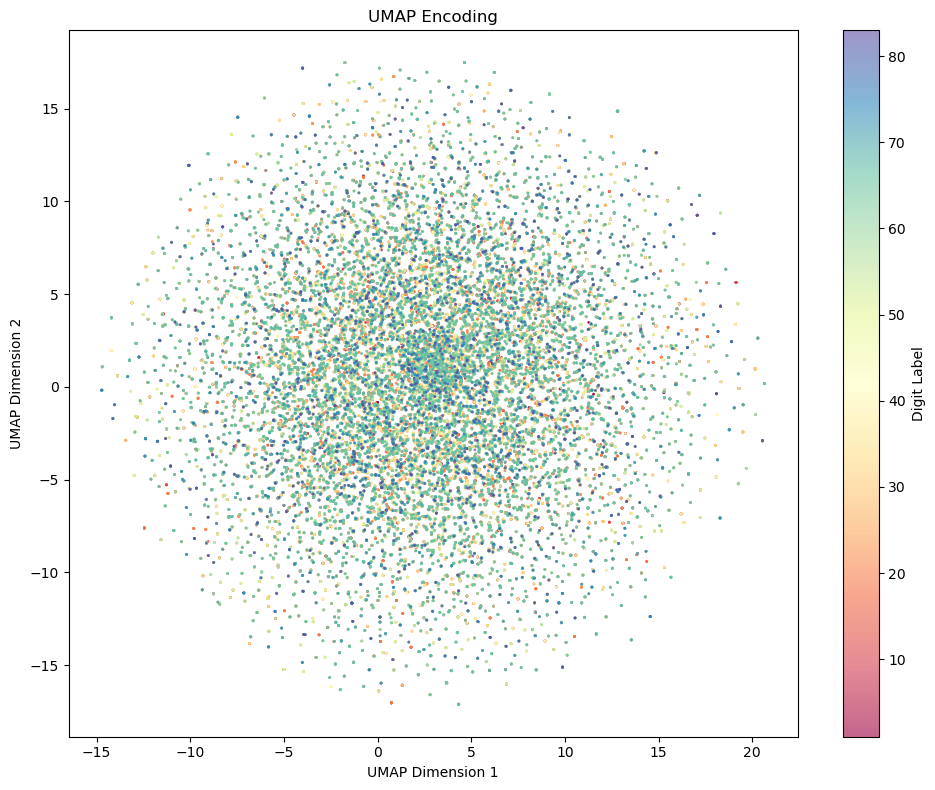

In [19]:
from umap import UMAP
import matplotlib.pyplot as plt

umap = UMAP()
# Fit and transform the data
X_train_umap = umap.fit_transform(training_x[:100000, :])

# Plot the results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=training_y[:100000], cmap="Spectral", s=1, alpha=0.6)
plt.colorbar(scatter, label="Digit Label")
plt.title("UMAP Encoding")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
# Show the plot
plt.tight_layout()
plt.show()

In [46]:
X = []
y = []
for key, val in ccl_mut_dict.items():
    label = np.ones((val.shape[0],))*ccl_name_dict[key]
    X.append(val)
    y.append(label)

In [48]:
mx.shape

(926, 36)

In [40]:
len(depmap_mutation_ref[depmap_mutation_ref["cell_line_display_name"] == "SW480"])

926

In [3]:
mutation_df.head()

,U2OS,MCF7,GAMG,LN229,SF295,HEC108,HEC151,HEC251,HEC265,HEC59,...,OC316,TDOTT,EWS502,TM87,MON,SW900,TEN,S117,NCIH157DM,ISTMES2
0,1,0,1,1,1,0,0,1,1,0,...,1,0,0,0,1,1,0,1,1,0
1,1,1,1,1,0,1,1,1,1,1,...,1,0,0,0,0,1,1,1,1,1
2,1,1,1,1,0,1,0,1,1,1,...,0,0,0,0,1,1,0,1,1,0
3,0,1,1,1,1,1,1,1,0,1,...,1,0,1,0,0,1,0,0,1,0
4,0,0,1,1,1,1,0,1,0,1,...,1,1,1,0,0,1,1,1,1,1


In [4]:
response_df.head()

,ccl_name,cpd_name,normalized_auc
0,U2OS,zebularine,0.382479
1,U2OS,maraviroc,0.437133
2,U2OS,DL-TBOA,0.434657
3,U2OS,triptolide,0.135200
4,U2OS,Bax channel blocker,0.332011


In [5]:
morgan_footprints_df.head()

,zebularine,maraviroc,DL-TBOA,triptolide,Bax channel blocker,CCT036477,sirolimus,OSW-1,brefeldin A,itraconazole,...,tucatinib,vindesine,vinblastine,UNC0631,pardoprunox,rubitecan,vinflunine,XL-647,PI3K-IN-2,verubulin
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,1,1,1,1,0,1,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
ccls = response_df["ccl_name"].unique().tolist()
cpds = response_df["cpd_name"].unique().tolist()
ccl_ref = mutation_df.columns.tolist()
cpd_ref = morgan_footprints_df.columns.tolist()

In [7]:
is_contained = set(ccls).issubset(set(ccl_ref))
print(is_contained) 

True


In [8]:
import numpy as np

In [9]:
# transfer data frame to matrix
mutation_ref = mutation_df.to_numpy()
# row represents cells and column represents mutations
mutation_ref = mutation_ref.T
# get cell line reference
cell_line_ref = mutation_df.columns.tolist()

In [10]:
# transfer data frame to matrix
morgan_footprints_ref = morgan_footprints_df.to_numpy()
# row represents drugs and column represents structures
morgan_footprints_ref = morgan_footprints_ref.T
# get drug reference
drug_ref = morgan_footprints_df.columns.tolist()

In [11]:
from umap import UMAP
import matplotlib.pyplot as plt

/N/u/zwu1/Quartz/.conda/envs/hdp_new/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/tmp/ipykernel_27190/4136302014.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], cmap="Spectral", s=1, alpha=0.6)


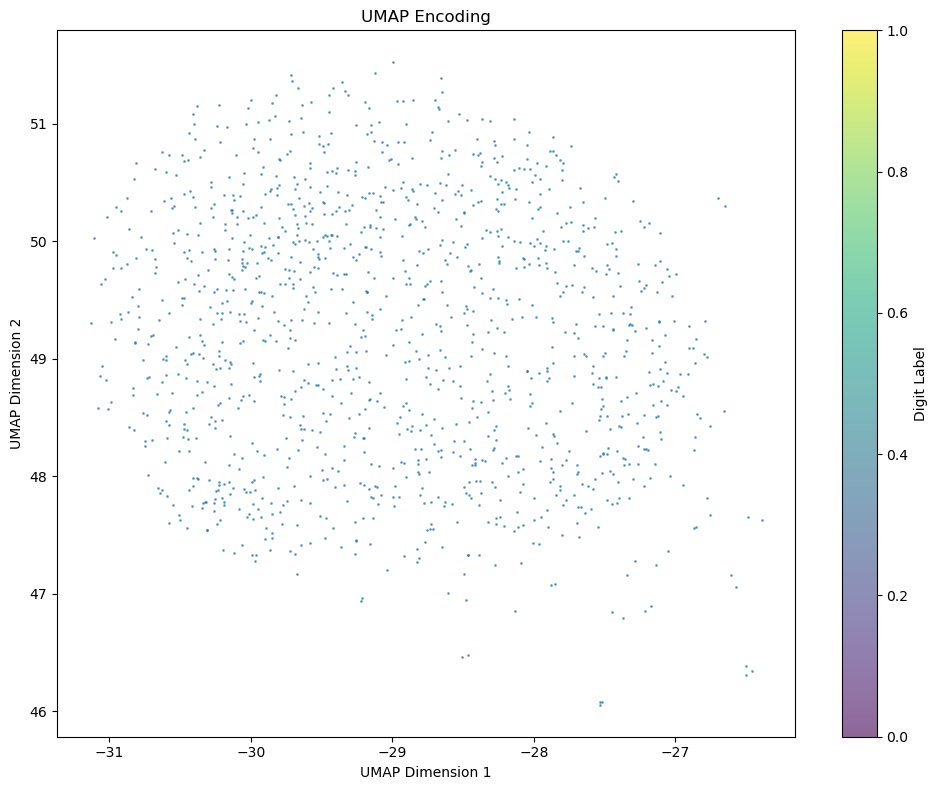

In [12]:
umap = UMAP()
# Fit and transform the data
X_train_umap = umap.fit_transform(mutation_ref)

# Plot the results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], cmap="Spectral", s=1, alpha=0.6)
plt.colorbar(scatter, label="Digit Label")
plt.title("UMAP Encoding")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
# Show the plot
plt.tight_layout()
plt.show()

/tmp/ipykernel_27190/3260410161.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], cmap="Spectral", s=1, alpha=0.6)


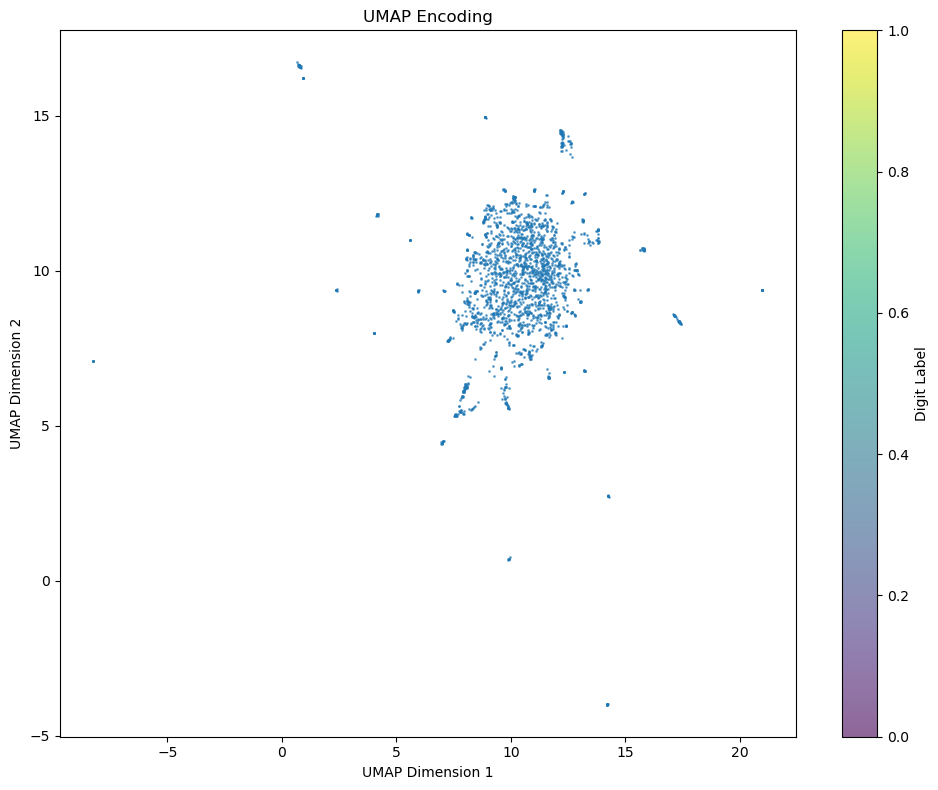

In [13]:
umap = UMAP()
# Fit and transform the data
X_train_umap = umap.fit_transform(morgan_footprints_ref)

# Plot the results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], cmap="Spectral", s=1, alpha=0.6)
plt.colorbar(scatter, label="Digit Label")
plt.title("UMAP Encoding")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
# Show the plot
plt.tight_layout()
plt.show()

In [18]:
from scipy.sparse import csr_matrix, vstack, hstack

In [19]:
df1 = response_df.sample(n=50000)  # ccl_name, cpd_name, auc
df2 = mutation_df.head(3008)  # Mutation matrix (ccl_name as columns)
df3 = morgan_footprints_df  # Morgan fingerprint matrix (cpd_name as columns)

# Function to extract mutation & fingerprint vectors in batches
def extract_sparse_vectors(df, column_names):
    data_list = []
    for col in column_names:
        if col in df.columns:
            data_list.append(csr_matrix(df[col].values.reshape(1, -1)).astype(np.uint8))
        else:
            # Handle missing columns by appending zero vectors
            data_list.append(csr_matrix(np.zeros((df.shape[0], 1), dtype=np.uint8)))
    return vstack(data_list, format="csr")

# 1. Extract mutation vectors (batch processing)
mutation_vectors = extract_sparse_vectors(df2, df1['ccl_name'])

# 2. Extract Morgan fingerprint vectors (batch processing)
fingerprint_vectors = extract_sparse_vectors(df3, df1['cpd_name'])

# 3. Extract AUC labels
labels = csr_matrix(df1['normalized_auc'].values.reshape(-1, 1))

# 4. Concatenate sparse matrices
dataset_sparse = hstack([mutation_vectors, fingerprint_vectors, labels], format="csr")

# (Optional) Convert to DataFrame for analysis
mutation_cols = [f'mutation_{i}' for i in range(mutation_vectors.shape[1])]
fingerprint_cols = [f'fingerprint_{i}' for i in range(fingerprint_vectors.shape[1])]
column_names = mutation_cols + fingerprint_cols + ['normalized_auc']

final_df = pd.DataFrame(dataset_sparse.toarray(), columns=column_names)

In [28]:
len(column_names)

5057

In [27]:
final_df.head()

,mutation_0,mutation_1,mutation_2,mutation_3,mutation_4,mutation_5,mutation_6,mutation_7,mutation_8,mutation_9,...,fingerprint_2039,fingerprint_2040,fingerprint_2041,fingerprint_2042,fingerprint_2043,fingerprint_2044,fingerprint_2045,fingerprint_2046,fingerprint_2047,normalized_auc
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.909039
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.181819
2,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.143134
3,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.970230
4,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.252412


In [36]:
data = final_df.to_numpy()
X = data[:,:-1]
y = data[:, -1:].reshape(-1)

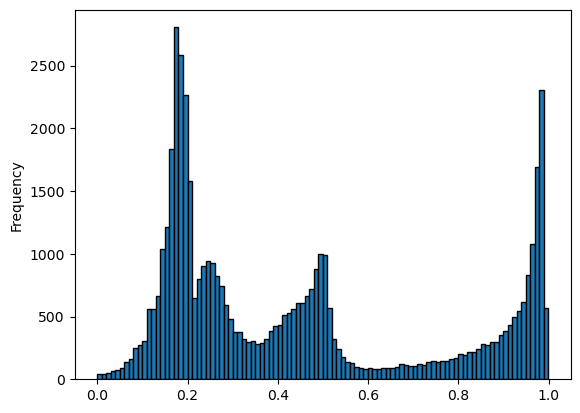

In [24]:
df1["normalized_auc"].plot(kind='hist', bins=100, edgecolor='black')
plt.show()

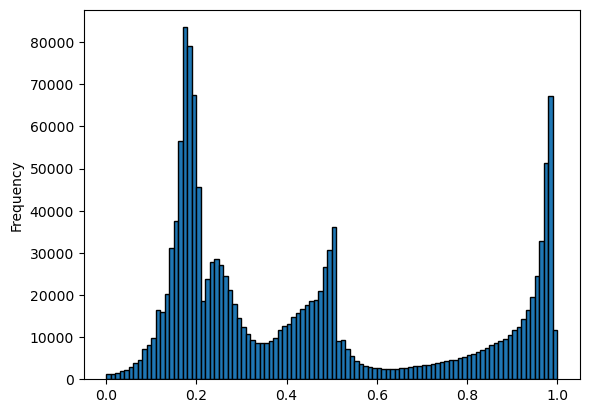

In [25]:
response_df["normalized_auc"].plot(kind='hist', bins=100, edgecolor='black')
plt.show()

In [37]:
X.shape

(50000, 5056)

In [38]:
y.shape

(50000,)

/home/leo/miniforge3/envs/hdp/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


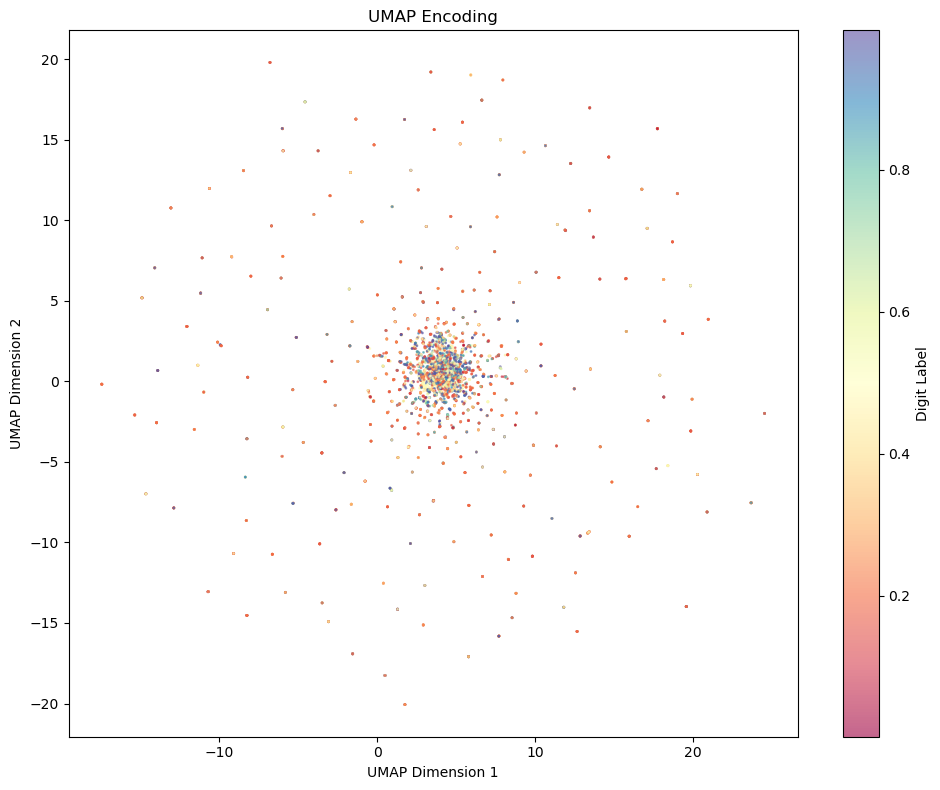

In [21]:
umap = UMAP()
# Fit and transform the data
X_train_umap = umap.fit_transform(X[:5000, :])

# Plot the results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y[:5000], cmap="Spectral", s=1, alpha=0.6)
plt.colorbar(scatter, label="Digit Label")
plt.title("UMAP Encoding")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
# Show the plot
plt.tight_layout()
plt.show()

In [22]:
response_df.to_csv("../dataset/Cancer/cell_drug_responses.csv", index=True)

In [ ]:
df1 = response_df  # ccl_name, cpd_name, auc
df2 = mutation_df.head(3008)  # Mutation matrix (ccl_name as columns)
df3 = morgan_footprints_df  # Morgan fingerprint matrix (cpd_name as columns)

# Function to extract mutation & fingerprint vectors in batches
def extract_sparse_vectors(df, column_names):
    data_list = []
    for col in column_names:
        if col in df.columns:
            data_list.append(csr_matrix(df[col].values.reshape(1, -1)).astype(np.uint8))
        else:
            # Handle missing columns by appending zero vectors
            data_list.append(csr_matrix(np.zeros((df.shape[0], 1), dtype=np.uint8)))
    return vstack(data_list, format="csr")

# 1. Extract mutation vectors (batch processing)
mutation_vectors = extract_sparse_vectors(df2, df1['ccl_name'])

# 2. Extract Morgan fingerprint vectors (batch processing)
fingerprint_vectors = extract_sparse_vectors(df3, df1['cpd_name'])


# 4. Concatenate sparse matrices
dataset_sparse = hstack([mutation_vectors, fingerprint_vectors], format="csr")